<a href="https://colab.research.google.com/github/BStricks/named_entity_recognition/blob/master/AZ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# OpenFDA Data Analysis

Using the data from the OpenFDA API (documentation at https://open.fda.gov/apis/drug/label/) to determine the average number of ingredients (spl_product_data_elements) contained in AstraZeneca (AZ) medicines per year.

Steps:

1.   Data collection
2.   Data transformation
3.   Data analysis



In [2]:
###mount drive
from google.colab import drive
drive.mount('/content/gdrive')

###change directory
%cd gdrive/My Drive/Colab Notebooks

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/Colab Notebooks


## Data collection

Decisions:

*   Manual Download of entire json data set from OpenFDA
*   Data stored in pandas dataframe

Notes:

*   NA


In [0]:
###imports
import json
import pandas as pd
pd.options.mode.chained_assignment = None  

#list of data frames to concatenate
frames = []

#for loop to read in separate files
for i in range(1,9):
  data = json.load(open('drug-label-000'+str(i)+'-of-0008.json'))
  df = pd.DataFrame(data["results"])
  frames.append(df)

#single dataframe of all files
result = pd.concat(frames,sort=True)

In [5]:
###examination of data frame
result

,abuse,abuse_table,accessories,active_ingredient,active_ingredient_table,adverse_reactions,adverse_reactions_table,alarms,alarms_table,animal_pharmacology_and_or_toxicology,animal_pharmacology_and_or_toxicology_table,ask_doctor,ask_doctor_or_pharmacist,ask_doctor_or_pharmacist_table,ask_doctor_table,assembly_or_installation_instructions,boxed_warning,boxed_warning_table,calibration_instructions,carcinogenesis_and_mutagenesis_and_impairment_of_fertility,carcinogenesis_and_mutagenesis_and_impairment_of_fertility_table,cleaning,clinical_pharmacology,clinical_pharmacology_table,clinical_studies,clinical_studies_table,components,components_table,contraindications,contraindications_table,controlled_substance,dependence,dependence_table,description,description_table,diagram_of_device,disposal_and_waste_handling,do_not_use,do_not_use_table,dosage_and_administration,...,recent_major_changes,recent_major_changes_table,references,references_table,residue_warning,risks,risks_table,route,safe_handling_warning,safe_handling_warning_table,set_id,spl_indexing_data_elements,spl_medguide,spl_medguide_table,spl_patient_package_insert,spl_patient_package_insert_table,spl_product_data_elements,spl_unclassified_section,spl_unclassified_section_table,statement_of_identity,statement_of_identity_table,stop_use,stop_use_table,storage_and_handling,storage_and_handling_table,summary_of_safety_and_effectiveness,teratogenic_effects,teratogenic_effects_table,troubleshooting,use_in_specific_populations,use_in_specific_populations_table,user_safety_warnings,version,veterinary_indications,warnings,warnings_and_cautions,warnings_and_cautions_table,warnings_table,when_using,when_using_table
0,NaN,NaN,NaN,[HPUS Active Ingredients Each dose contains eq...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[Directions Initially depress pump until prime...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2eb93d7c-330f-4b93-e054-00144ff88e88,NaN,NaN,NaN,NaN,NaN,"[BrightSpark Arg nit, Arsenicum iod, Hyoscyamu...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,"[Warnings If symptoms persist or worsen, consu...",NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,[6 ADVERSE REACTIONS Use of levocetirizine dih...,"[<table ID=""_RefID0EWPAC"" width=""75%""> <captio...",NaN,NaN,[13.2 Animal Toxicology Reproductive Toxicolog...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[13.1 Carcinogenesis, Mutagenesis, Impairment ...",NaN,NaN,[12 CLINICAL PHARMACOLOGY 12.1 Mechanism of Ac...,NaN,[14 CLINICAL STUDIES 14.1 Seasonal and Perenni...,"[<table width=""100%""> <col width=""19%""/> <col ...",NaN,NaN,[4 CONTRAINDICATIONS The use of levocetirizine...,NaN,NaN,NaN,NaN,[11 DESCRIPTION Levocetirizine dihydrochloride...,NaN,NaN,NaN,NaN,NaN,[2 DOSAGE AND ADMINISTRATION Levocetirizine di...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,b84ccb27-9c52-43b9-9a46-8f52a571045e,NaN,NaN,NaN,NaN,NaN,[levocetirizine dihydrochloride levocetirizine...,"[Manufactured for: Vensun Pharmaceuticals, Inc...",NaN,NaN,NaN,NaN,NaN,[Storage: Store at 20° to 25°C (68° to 77°F); ...,NaN,NaN,"[Teratogenic Effects: In rats and rabbits, lev...",NaN,NaN,[8 USE IN SPECIFIC POPULATIONS 1.Renal Impairm...,NaN,NaN,1,NaN,NaN,[5 WARNINGS AND PRECAUTIONS 1.Avoid engaging i...,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,[Active ingredient (in each extended-release t...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[Ask a doctor before use if you have •persiste...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[Do not use •for children under 12 years of age],NaN,"[Directions •do not crush, chew, or break tabl...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1e99f1a3-95bc-4108-8395-430a32c4f292,NaN,NaN,NaN,NaN,NaN,[Good Neighbor Pharmacy Mucus ER Guaifenesin G...,NaN,NaN,NaN,NaN,[Stop use and ask a doctor if •cough lasts mor...,NaN,[Other information •store between 20°-25°C (68...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,[War

## Data transformation

Decisions:

*   **Extract all AstraZeneca drugs**; a preliminary review of the JSON files revealed that there were three broad cases where AZ could be linked to a drug. As a manufacturer, as a distributer, and as the original inventor for subsequent generics. The decision was made to label a drug as AZ for the first two cases.
*   **Extract number of ingredients**; the brief asked for a count of ingredients in 'spl_product_data_elements', this was problematic because this list is not consistently delimited and without domain knowledge or an easily accessible lookup table I couldn't use it to count ingredients. Instead I used the description field and a more manual regex approach to count the number of ingredients. 
*   **Extract year effective**; the field listing 'effective time' is used to indicate when the drug was effective from, this was chosen for our 'per year' variable.
*   **Extract route**; the first field to use was from the 'openfda' field, if this wasn't available a regex solution scanned the description to find references to routes.


Notes:
*   The biggest issue with the data set is missing data from fields; the most reliable field was 'description'. Instead of excluding the drugs with missing fields a regex solution was developed for the description field.
*   Exclude generic versions of AZ drugs should more accurately reflect trends over time, as the generics were originally developed at a much earlier date. 
*   Ideally the number of ingredients in the generic version of a drug would be re-timestampped to the effective date of the original AZ version, this was felt to be out of scope.  
*   For ingredient count all the active and inactive ingredients were included; this could be refined to remove some inactive compenents by someone with more domain knowledge. I recognise that the ingedient count regex method is imperfect and would require more work; currently a lot of the counts are defaulting to one because they are unable to recognise ingredients in the description.



In [0]:
#select columns
target_cols = ["spl_unclassified_section","openfda","spl_product_data_elements",
              "active_ingredient","description","effective_time"]
result_restricted = result.loc[:,target_cols]

#replace NaNs with empty list
result_restricted.iloc[:,0] = result_restricted.iloc[:,0].apply(lambda d: d if isinstance(d, list) else [])
result_restricted.iloc[:,2] = result_restricted.iloc[:,2].apply(lambda d: d if isinstance(d, list) else [])
result_restricted.iloc[:,4] = result_restricted.iloc[:,4].apply(lambda d: d if isinstance(d, list) else [])



In [0]:
###extract all AZ drugs

#function to check for either manufacturer or distributor
def manu_dist(dataframe,search_term):
  
  index = []
  for i in range(0,len(dataframe)):

    dict1 = dataframe.iloc[i,1]
    #manufacturer is stored within a dictionary within the 1st cell  
    try:
      manu_name = dict1.get('manufacturer_name')
      if search_term in manu_name[0]:
        index.append(i)
    except:
      pass

    dist = dataframe.iloc[i,0]
    for a in dist:
      if search_term in a:
        index.append(i) 

  set_index = list(set(index))  
  df = dataframe.iloc[set_index]
  return df
  
  
AZ_df = manu_dist(result_restricted,"AstraZeneca Pharmaceuticals LP")  
  


In [0]:
###extract count of ingredients
import re

def ingredient_count(dataframe):
  ingredients = []

  for i in range(0,len(dataframe)):
      counter = 1

      try:
        text = dataframe.iloc[i,4][0]
        text0 = re.split('contains |contain |contained |containing',text)[1]
        text1 = re.split('\. |and the following inactive ingredients',text0)[0]
        counter += text1.count(" and ")
      except:
        pass

      try:
        text = dataframe.iloc[i,4][0]
        text0 = re.split('deliver',text)[1]
        text1 = re.split('\. |and the following inactive ingredients',text0)[0]
        counter += text1.count(" and ")
      except:
          pass

      try:
        text = dataframe.iloc[i,4][0]
        text2 = re.split('inactive ingredients',text)[1]
        text3 = re.split('\.',text2)[0]
        counter += text3.count(",")
        counter += 1
      except:
        pass

      try:
        text = dataframe.iloc[i,4][0]
        text2 = re.split('inactive ingredients',text)[2]
        text3 = re.split('\.',text2)[0]
        counter += text3.count(",")
        counter += 1
      except:
        pass

      try:
        text = dataframe.iloc[i,4][0]
        text2 = re.split('composed of',text)[1]
        text3 = re.split('\. ',text2)[0]
        counter += text3.count(",")
        counter += 1
      except:
        pass

      ingredients.append(counter)    
  
  df = dataframe
  df.loc[:,'ingredients'] = ingredients
  return df
  
AZ_df = ingredient_count(AZ_df)

In [0]:
###extract year

def year(dataframe):
  df = dataframe
  for i in range(0, len(dataframe)):   
    df.iloc[i,5] = df.iloc[i,5][0:4]
  return df
  
AZ_df = year(AZ_df)

In [0]:
###extract name

def names(dataframe):
  names = []

  for i in range(0, len(dataframe)):
    desc = dataframe.iloc[i,4][0]
    name = re.split('DESCRIPTION',desc)[1]
    name2 = name.split(' ')[1]
    names.append(name2)

  for a in range(0,len(dataframe)):
    if names[a] == "The":
      desc2 = dataframe.iloc[a,2][0]
      name = desc2.split(' ')[0]
      names[a] = name
    else:
      pass

  df = dataframe
  df['name'] = names
  return df


AZ_df = names(AZ_df)

In [32]:
AZ_df

,spl_unclassified_section,openfda,spl_product_data_elements,active_ingredient,description,effective_time,ingredients,name
16769,[],{'manufacturer_name': ['AstraZeneca Pharmaceut...,[FASENRA Benralizumab BENRALIZUMAB BENRALIZUMA...,NaN,[11 DESCRIPTION Benralizumab is a humanized mo...,2017,3,Benralizumab
4482,[],{'manufacturer_name': ['AstraZeneca Pharmaceut...,[XIGDUOXR dapagliflozin and metformin hydrochl...,NaN,[11 DESCRIPTION XIGDUO XR (dapagliflozin and m...,2019,13,XIGDUO
10916,[],{'manufacturer_name': ['AstraZeneca Pharmaceut...,[CAPRELSA Vandetanib VANDETANIB VANDETANIB CAL...,NaN,[11. DESCRIPTION Vandetanib has the chemical n...,2016,9,Vandetanib
5574,[Manufactured by: Bristol-Myers Squibb Company...,{},[ONGLYZA SAXAGLIPTIN saxagliptin hydrochloride...,NaN,[11 DESCRIPTION Saxagliptin is an orally-activ...,2013,10,Saxagliptin
1673,[],{'manufacturer_name': ['AstraZeneca Pharmaceut...,[BYDUREON exenatide EXENATIDE EXENATIDE POLY(D...,NaN,[11 DESCRIPTION BYDUREON (exenatide extended-r...,2019,7,BYDUREON
14992,[],{'manufacturer_name': ['AstraZeneca Pharmaceut...,[Byetta exenatide exenatide exenatide metacres...,NaN,[11 DESCRIPTION BYETTA (exenatide) is a synthe...,2018,3,BYETTA
13904,[Manufactured for: Bristol-Myers Squibb Compan...,{},[Byetta exenatide exenatide exenatide metacres...,NaN,[11 DESCRIPTION BYETTA (exenatide) is a synthe...,2014,3,BYETTA
7570,[],{'manufacturer_name': ['AstraZeneca Pharmaceut...,[QTERN dapagliflozin and saxagliptin DAPAGLIFL...,NaN,[11 DESCRIPTION QTERN tablets for oral use con...,2019,12,QTERN
1428,[],{'manufacturer_name': ['AstraZeneca Pharmaceut...,[KOMBIGLYZEXR SAXAGLIPTIN AND METFORMIN HYDROC...,NaN,[11 DESCRIPTION KOMBIGLYZE XR (saxagliptin and...,2019,10,KOMBIGLYZE
6393,[],{'manufacturer_name': ['AstraZeneca Pharmaceut...,[ATACAND HCT Candesartan cilexetil and Hydroch...,NaN,[DESCRIPTION ATACAND HCT (candesartan cilexeti...,2016,8,ATACAND


# Part A

In [0]:
AZ_df2=AZ_df
AZ_df2['name'] = AZ_df2[['effective_time','ingredients','name']].groupby(['effective_time'])['name'].transform(lambda x: ','.join(x))
AZ_df2[['name','effective_time','ingredients']].drop_duplicates()
AZ_df3 = AZ_df2.groupby(['effective_time','name'], as_index=False)['ingredients'].mean()


In [34]:
print("Mean number of ingredients per year")
AZ_df3

Mean number of ingredients per year


,effective_time,name,ingredients
0,2007,NOLVADEX®,1.000000
1,2012,Saxagliptin,10.000000
2,2013,"Saxagliptin,KOMBIGLYZE",10.000000
3,2014,"BYETTA,MYALEPT,BYDUREON,Dapagliflozin",5.500000
4,2016,"Vandetanib,ATACAND,ATACAND,TOPROL-XL,,ZOLADEX®...",6.900000
5,2017,"Benralizumab,CASODEX®,Saxagliptin,Quetiapine,C...",5.600000
6,2018,"BYETTA,Olaparib,Saxagliptin,Esomeprazole,SEROQ...",8.071429
7,2019,"XIGDUO,BYDUREON,QTERN,KOMBIGLYZE,MERREM®,Olapa...",6.333333


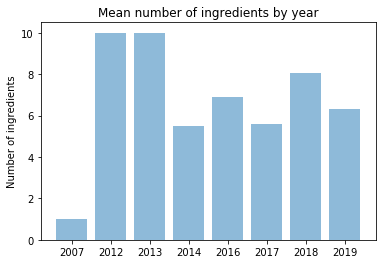

In [35]:
###plot
import matplotlib.pyplot as plt

plt.bar(AZ_df3.iloc[:,0], AZ_df3.iloc[:,2], align='center', alpha=0.5)
plt.ylabel('Number of ingredients')
plt.title('Mean number of ingredients by year')

plt.show()

# Part B

Repeat the same analysis, calculate the average number of ingredients per year and per delivery route for all manufacturers.

In [0]:
###extract route
#the results were restricted to drugs where the description field was available
dfdesc = result_restricted
dfdesc = dfdesc[dfdesc['description'].map(lambda d: len(d)) > 0]
#ingredient counts and year were added
df_b = ingredient_count(dfdesc)
df_b = year(df_b)


In [0]:
###find routes

#route list
routes = ['conjunctival', 'intradermal', 'vaginal', 'urethral', 'intravitreal', 'topical', 'intrasinal', 'intratympanic', 'intrapleural', 'transmucosal', 'intramuscular', 'respiratory (inhalation)', 'intra-arterial', 'intraocular', 'periodontal', 'na', 'intravascular', 'retrobulbar', 'nasal', 'intraspinal', 'buccal', 'parenteral', 'intracaudal', 'soft tissue', 'infiltration', 'dental', 'submucosal', 'cutaneous', 'occlusive dressing technique', 'extracorporeal', 'ureteral', 'perineural', 'oropharyngeal', 'enteral', 'transdermal', 'rectal', 'intraventricular', 'percutaneous', 'intralesional', 'subconjunctival', 'intraperitoneal', 'sublingual', 'ophthalmic', 'intramedullary', 'subarachnoid', 'intravenous', 'intracanalicular', 'intracavitary', 'epidural', 'endotracheal', 'intrasynovial', 'intracavernous', 'intralymphatic', 'subcutaneous', 'irrigation', 'intrabronchial', 'intravesical', 'intrathecal', 'intracardiac', 'nasogastric', 'intra-articular', 'oral', 'intrauterine', 'auricular (otic)']
routes = [x.lower() for x in routes]
route_list = []

for i in range(0,len(df_b)):
  
    #route is stored within a dictionary within the cell  
    dict1 = df_b.iloc[i,1]
    route = dict1.get('route')
    desc = df_b.iloc[i,4][0]
    
    if route:
      route_list.append(route[0])
    
    #the alternative is to check for route manually in description
    elif any(word in desc for word in routes):
      desc_route = []
      for a in routes:
        if a in desc:
          desc_route.append(a)
      set_route = set(desc_route)
      route_list.append(list(set_route)[0])
    
    else:
      route_list.append("NA")

routes_list = [x.lower() for x in route_list]
df_b['route'] = routes_list


In [0]:
df_b2 = df_b
df_b2 = df_b2.groupby(['effective_time','route'], as_index=False)['ingredients'].mean()


In [71]:
print("Mean number of ingredients per year")
df_b2

Mean number of ingredients per year


,effective_time,route,ingredients
0,1960,oral,1.000000
1,1971,oral,1.000000
2,1973,oral,5.000000
3,1974,oral,15.000000
4,1977,oral,1.000000
5,1978,oral,11.000000
6,1983,oral,1.500000
7,1986,oral,1.500000
8,1987,oral,3.500000
9,1990,topical,1.000000


# Optional

1.   Predictive model
        *   one continuous independent variable and one categorical independent variable 
        *   one continuous dependent variable
        *   if the assumptions of linear regression were met then i'd perform a multiple regression analysis
2.   Common drug interactions
        *   a lookup of common druges could be applied to the 'drug interactions' field, and the containing sentence extracted. Looking for phrases such as 'increased risk of x' and 'may exacerbate x', to create a new attribute for 'x'.
3.   Tool deployment
        *   a model of the relationships between increased risks from the drug interactions and ingredients contained within each of the interacting drugs; to identify common ingredients linked to increased risks.
        


